#Model overwiew

In [3]:
# import required libraries

'''
this is for use in google colab since it doesnt have
implicit installed by default
!pip install implicit
'''

import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from threadpoolctl import threadpool_limits
import os

# pip install implicit pandas numpy scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 46.8 MB/s eta 0:00:00


##Getting data

We need to get data from provided databases and format it so we can make the matrix and factorize it later. Getting rid of watched but not rated entires in the ratings table (there is no point in keeping unrated data, this way we reset it to unrated instead of having it misinterpreted as rated 0), as well as rows with missing data from the anime table.

In [4]:
# get data
file_path = "../data"
anime = pd.read_csv(file_path + "/anime.csv")
ratings = pd.read_csv(file_path + "/rating.csv")

# drop rows with missing values in 'genre' or 'rating' and missing ids
anime = anime.dropna(subset=["genre", "rating"])
ratings = ratings.dropna(subset=["anime_id", "user_id"])
anime = anime.dropna(subset=["anime_id"])

# drop watched anime without rating
ratings = ratings[ratings["rating"] != -1]

FileNotFoundError: [Errno 2] No such file or directory: '../data/anime.csv'

More data related stuff. Creating mappings between indexes and ids. then makig sure there are no missing indexes by dropping it. There is so much data that deleting stuff makes little difference. We still end up with a big data set at the end

In [ ]:
# create a mapping of anime_id to index for matrix creation
anime_id_to_index = {
    anime_id: idx for idx, anime_id in enumerate(anime["anime_id"].unique())
}
user_id_to_index = {
    user_id: idx for idx, user_id in enumerate(ratings["user_id"].unique())
}

# add index mappings to the ratings dataframe
ratings["anime_idx"] = ratings["anime_id"].map(anime_id_to_index)
ratings["user_idx"] = ratings["user_id"].map(user_id_to_index)

# drop missing ids again
ratings = ratings.dropna(subset=["anime_idx", "user_idx"])

# check for invalid mappings
print(ratings['anime_id'].isin(anime_id_to_index.keys()).all())  # should return True
print(ratings['user_id'].isin(user_id_to_index.keys()).all())   # should return True

###Matrix creation
Creating matrix in a user x anime format filling it with existing ratings and leaving tall the other spaces empty, making it a sparse matrix (mostly empty).

In [ ]:
#BUILDING THE MATRIX

# create a sparse matrix of user-anime interactions
interaction_matrix = coo_matrix(
    (ratings["rating"], (ratings["user_idx"], ratings["anime_idx"])),
    shape=(len(user_id_to_index), len(anime_id_to_index)),
)

print("Interaction Matrix Shape:", interaction_matrix.shape)

Applying logarythmic confidence weighting to our data. Helps with accuracy of the model, adds more confidence into rating values.

In [ ]:
# start with the original sparse matrix
interaction_matrix_conf = interaction_matrix.copy()

# convert to binary (implicit feedback)
interaction_matrix_conf.data = np.ones_like(interaction_matrix.data)

# apply confidence weighting
interaction_matrix_conf.data = 1 + np.log(1 + interaction_matrix.data)

Last step here is to convert the matrix to CSR (compressed sparse row) format. Makes the row access and matrix-vector multiplications faster. Attaching an example from Wikipedia as it is great at illustarting the concept.

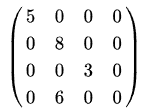 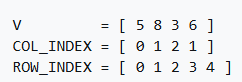

In [ ]:
# convert interaction matrix to CSR format
interaction_matrix_conf_csr = interaction_matrix_conf.tocsr()

###Training the actual model

At the end we feed our prepared matrix to an ALS (alternating least squares) algorithm. Basic idea of matrix factorization with ALS algorithm is we take the interaction matrix and split it into two matrices both with the same amout of features (in our case we would split it into user and anime). We dont control what the features are, it is the machine learning magic. Next based on those two smaller matrices when we want to get info from an empty value in the main matrix, we perform simple vertex multiplication between the proper user vector and anime vector. If we want to find the best recommendations for a certain user we simply multiply that users vector by the whole anime matrix to fill in the squares and then pick the best values from the new data.
But how do we actually find the two matrices? That's what ALS is for. ALS works by alternating between two steps:
1. fixing 1st matrix and predicting the 2nd one
2. fixing 2nd matrix and predicting the 1st one
After a set number of iterations we get a proper set of matrices that we will use to help us predict empty squares.

In [ ]:
# TRAIN MODEL

# limit OpenBLAS threads for performance
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# initialize the ALS model
als_model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=15)

# train the model with proper threading limits
with threadpool_limits(limits=1, user_api="blas"):
    als_model.fit(interaction_matrix_conf_csr.T)

print("ALS model training completed!")

